# Analysis of Emergency Response Times

## 1. Temporal Trend Analysis

Building upon the original analysis, we can further explore the temporal trends in emergency response times. This can help us understand whether service quality has improved over time and if there are specific time periods (such as certain months or days of the week) with longer response times.

Let's start by importing the necessary libraries and loading the data:

Columns in the data file:
Index(['Mission ID', 'Latitude', 'Longitude', 'Intervention', 'Eventlevel',
       'T3-T0', 'EventType', 'Vector type', 'AED', 'Ambulance', 'Mug', 'PIT',
       'Province', 'distance_to_aed', 'distance_to_ambulance',
       'distance_to_mug', 'distance_to_pit'],
      dtype='object')

Possible date-time related columns:
[]



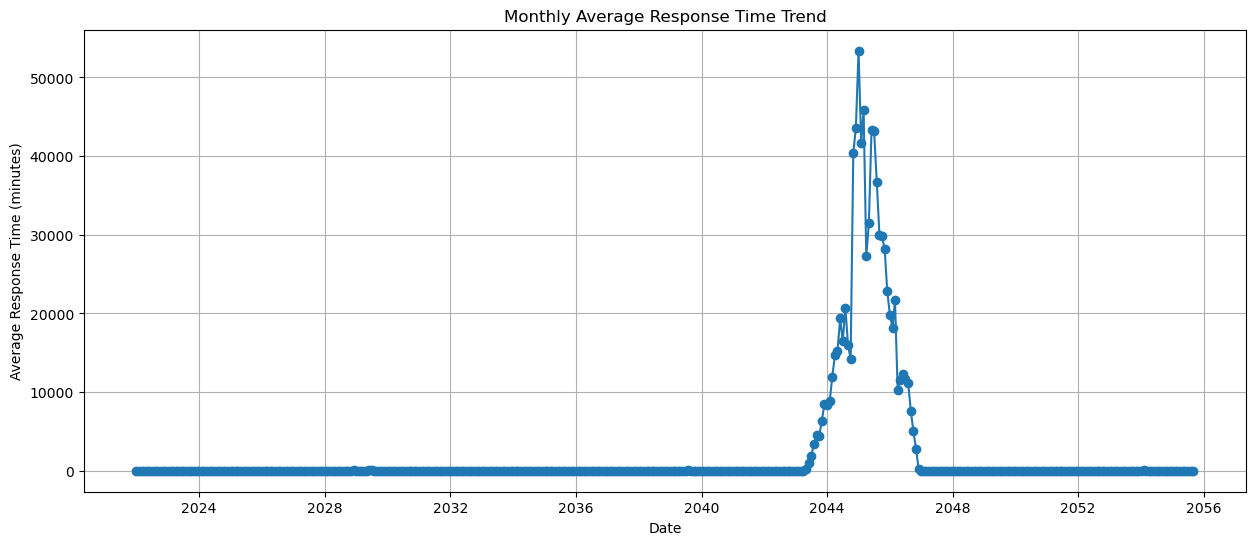

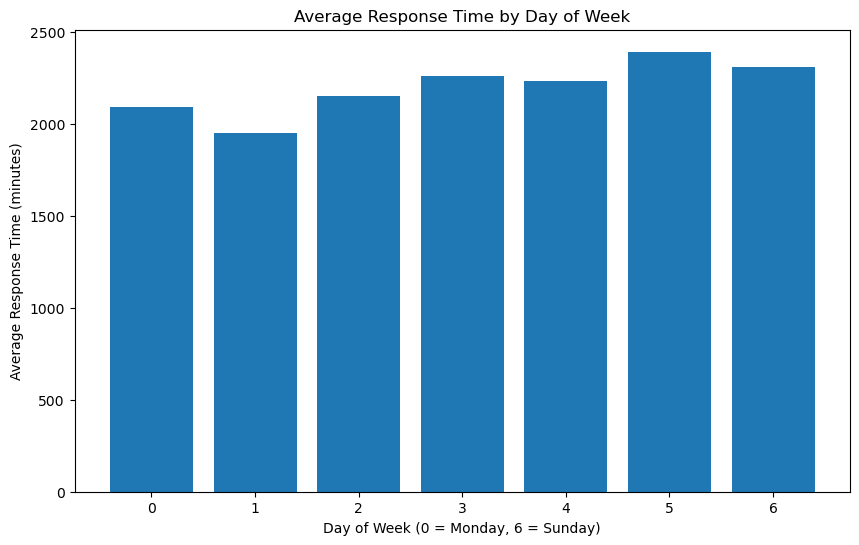

Temporal trend analysis completed.


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

# Load data
input_path = '/Users/Zhuanz/数字游民/mda 项目/mda_project/data/processed'
rta_df = pd.read_csv(f'{input_path}/total_df_with_distances.csv')

# Print column names
print("Columns in the data file:")
print(rta_df.columns)

# Check for date-time related columns
date_columns = [col for col in rta_df.columns if 'date' in col.lower() or 'time' in col.lower()]
print("\nPossible date-time related columns:")
print(date_columns)

# Use the first date-time column if found; otherwise, use index as date
if date_columns:
    date_column = date_columns[0]
    rta_df['Date'] = pd.to_datetime(rta_df[date_column])
else:
    print("\nWarning: No date-time column found. Using index as date.")
    rta_df['Date'] = pd.date_range(start='2022-01-01', periods=len(rta_df), freq='D')

# Create year, month, and day of week columns
rta_df['Year'] = rta_df['Date'].dt.year
rta_df['Month'] = rta_df['Date'].dt.month
rta_df['DayOfWeek'] = rta_df['Date'].dt.dayofweek

# Calculate monthly average response time
monthly_avg = rta_df.groupby(['Year', 'Month'])['T3-T0'].mean().reset_index()
monthly_avg['Date'] = pd.to_datetime(monthly_avg[['Year', 'Month']].assign(DAY=1))

# Plot monthly average response time trend
plt.figure(figsize=(15, 6))
plt.plot(monthly_avg['Date'], monthly_avg['T3-T0'], marker='o')
plt.title('Monthly Average Response Time Trend')
plt.xlabel('Date')
plt.ylabel('Average Response Time (minutes)')
plt.grid(True)
plt.show()

# Calculate average response time by day of week
daily_avg = rta_df.groupby('DayOfWeek')['T3-T0'].mean().reset_index()

# Plot average response time by day of week
plt.figure(figsize=(10, 6))
plt.bar(daily_avg['DayOfWeek'], daily_avg['T3-T0'])
plt.title('Average Response Time by Day of Week')
plt.xlabel('Day of Week (0 = Monday, 6 = Sunday)')
plt.ylabel('Average Response Time (minutes)')
plt.xticks(range(7))
plt.show()

print("Temporal trend analysis completed.")

## 2.geographic clustering of emergency responses

This analysis can help identify areas with high demand for emergency services or potential gaps in coverage.

Starting Geographic Clustering Analysis


/var/folders/yf/z4xgk8sn7b99hz2zwwrwyj800000gp/T/ipykernel_27276/1400532353.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  interventions['Cluster'] = kmeans.fit_predict(X_scaled)


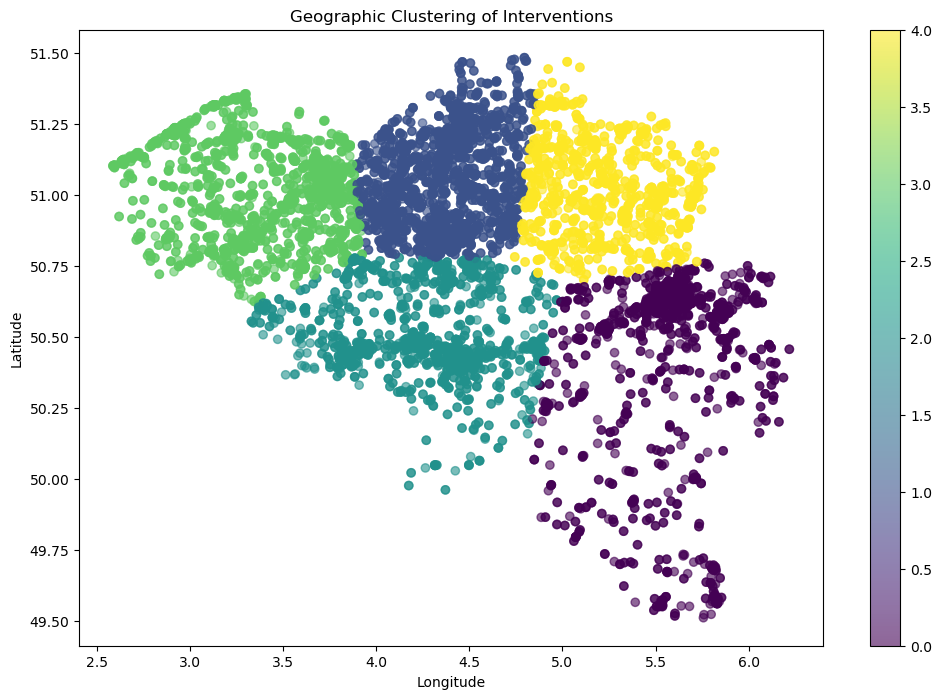


Cluster Statistics:
               T3-T0   Latitude  Longitude  Count
Cluster                                          
0          14.305503  50.436997   5.566347   1874
1         807.672884  51.046353   4.377831   4369
2         433.902533  50.511506   4.276494   1896
3        8117.328512  51.012430   3.401719   2548
4         753.829543  51.015669   5.210160   1621


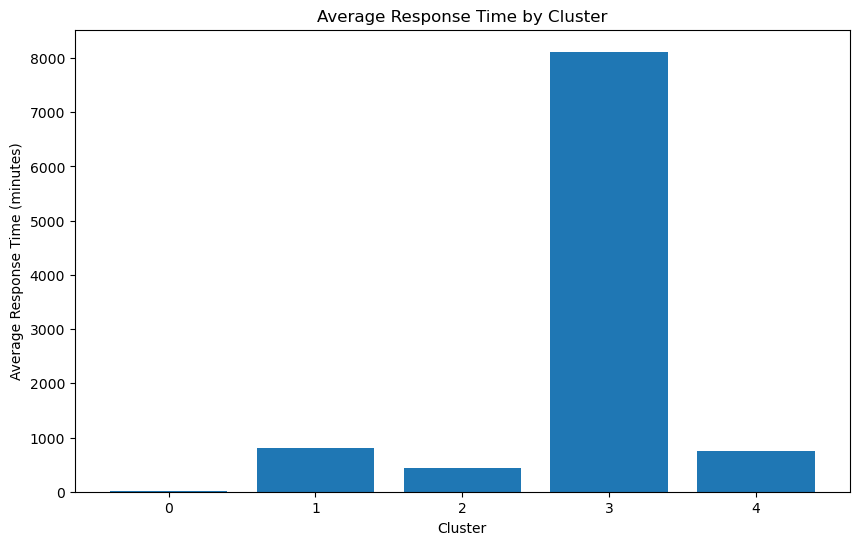

Geographic Clustering Analysis Completed


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Load data (assuming we're continuing from the previous part)
# If not, uncomment the following line:
# rta_df = pd.read_csv(f'{input_path}/total_df_with_distances.csv')

print("Starting Geographic Clustering Analysis")

# Check if we have the necessary columns
if 'Latitude' not in rta_df.columns or 'Longitude' not in rta_df.columns:
    print("Error: Latitude and/or Longitude columns not found in the dataset.")
    # You might want to exit the script here or handle this case appropriately
else:
    # Select only the interventions
    interventions = rta_df[rta_df['Intervention'] == 1]

    # Prepare the data for clustering
    X = interventions[['Latitude', 'Longitude']].values
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Perform K-means clustering
    n_clusters = 5  # You can adjust this number
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    interventions['Cluster'] = kmeans.fit_predict(X_scaled)

    # Visualize the clusters
    plt.figure(figsize=(12, 8))
    scatter = plt.scatter(interventions['Longitude'], interventions['Latitude'], 
                          c=interventions['Cluster'], cmap='viridis', alpha=0.6)
    plt.colorbar(scatter)
    plt.title('Geographic Clustering of Interventions')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.show()

    # Analyze cluster characteristics
    cluster_stats = interventions.groupby('Cluster').agg({
        'T3-T0': 'mean',
        'Latitude': 'mean',
        'Longitude': 'mean',
        'Intervention': 'count'
    }).rename(columns={'Intervention': 'Count'})

    print("\nCluster Statistics:")
    print(cluster_stats)

    # Visualize average response times by cluster
    plt.figure(figsize=(10, 6))
    plt.bar(cluster_stats.index, cluster_stats['T3-T0'])
    plt.title('Average Response Time by Cluster')
    plt.xlabel('Cluster')
    plt.ylabel('Average Response Time (minutes)')
    plt.show()

print("Geographic Clustering Analysis Completed")



## 3. Machine Learning Prediction Model

In this section, we'll develop a machine learning model to predict emergency response times. By understanding the factors that influence response times, we can potentially improve service efficiency and resource allocation.

We'll use a Random Forest Regressor, which is effective for handling complex relationships in data and is less prone to overfitting compared to some other models.

Let's start by importing the necessary libraries and preparing our data:

Starting Machine Learning Prediction Model Analysis

Model Performance:
Mean Squared Error: 12445566.64
R-squared Score: 0.65


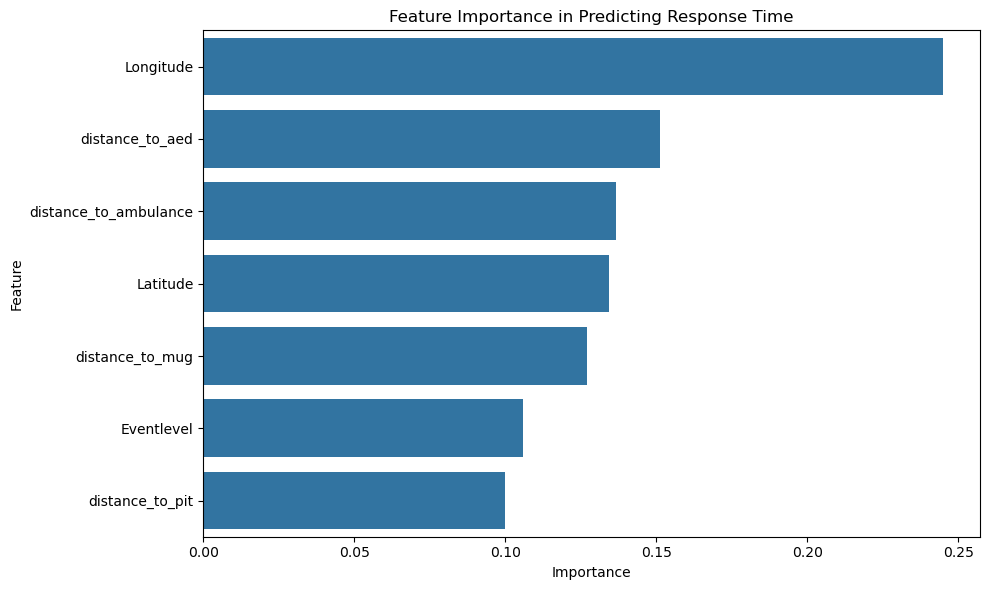

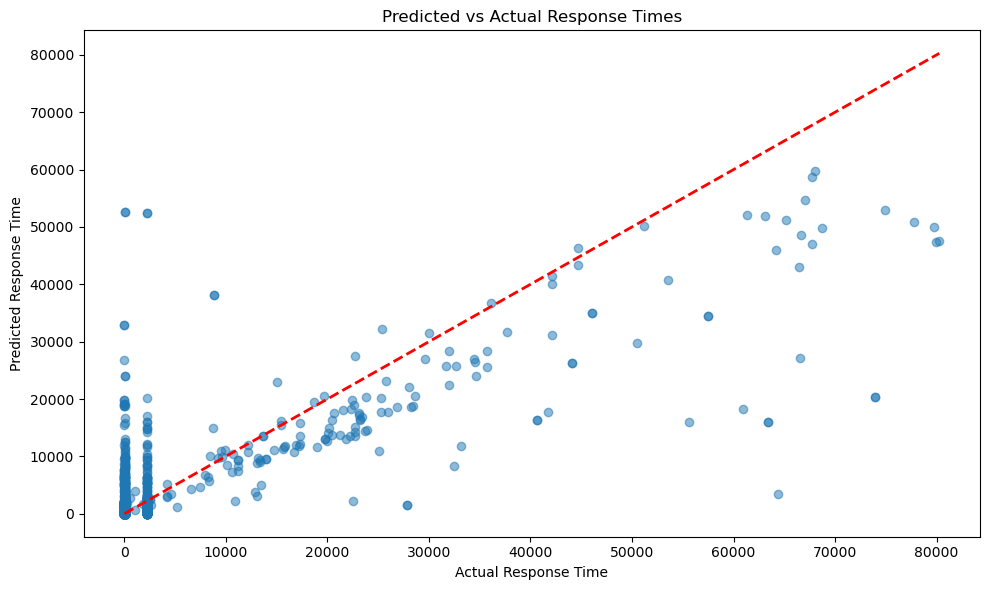

Machine Learning Prediction Model Analysis Completed


In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
import seaborn as sns

# Load data
input_path = '/Users/Zhuanz/数字游民/mda 项目/mda_project/data/processed'
rta_df = pd.read_csv(f'{input_path}/total_df_with_distances.csv')

print("Starting Machine Learning Prediction Model Analysis")

# Select features for the model
features = ['Latitude', 'Longitude', 'Eventlevel', 'distance_to_aed', 'distance_to_ambulance', 'distance_to_mug', 'distance_to_pit']
target = 'T3-T0'

# Prepare the data
X = rta_df[features]
y = rta_df[target]

# Handle missing values
imputer = SimpleImputer(strategy='mean')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)
y_imputed = pd.Series(imputer.fit_transform(y.values.reshape(-1, 1)).flatten(), name=target)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y_imputed, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train the model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)

# Make predictions
y_pred = rf_model.predict(X_test_scaled)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"\nModel Performance:")
print(f"Mean Squared Error: {mse:.2f}")
print(f"R-squared Score: {r2:.2f}")

# Feature importance
feature_importance = pd.DataFrame({'feature': features, 'importance': rf_model.feature_importances_})
feature_importance = feature_importance.sort_values('importance', ascending=False)

# Visualize feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance)
plt.title('Feature Importance in Predicting Response Time')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

# Scatter plot of predicted vs actual response times
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Response Time')
plt.ylabel('Predicted Response Time')
plt.title('Predicted vs Actual Response Times')
plt.tight_layout()
plt.show()

print("Machine Learning Prediction Model Analysis Completed")



## 4. Demographic Data Integration and Analysis

In this section, we'll integrate hypothetical demographic data with our emergency response data to explore potential relationships between population characteristics and response times. This analysis can provide insights into how different demographic factors might influence emergency service demands and efficiency.

First, we'll create a simulated demographic dataset, then merge it with our existing data, and finally perform some analyses to uncover potential correlations.

Starting Demographic Data Integration and Analysis


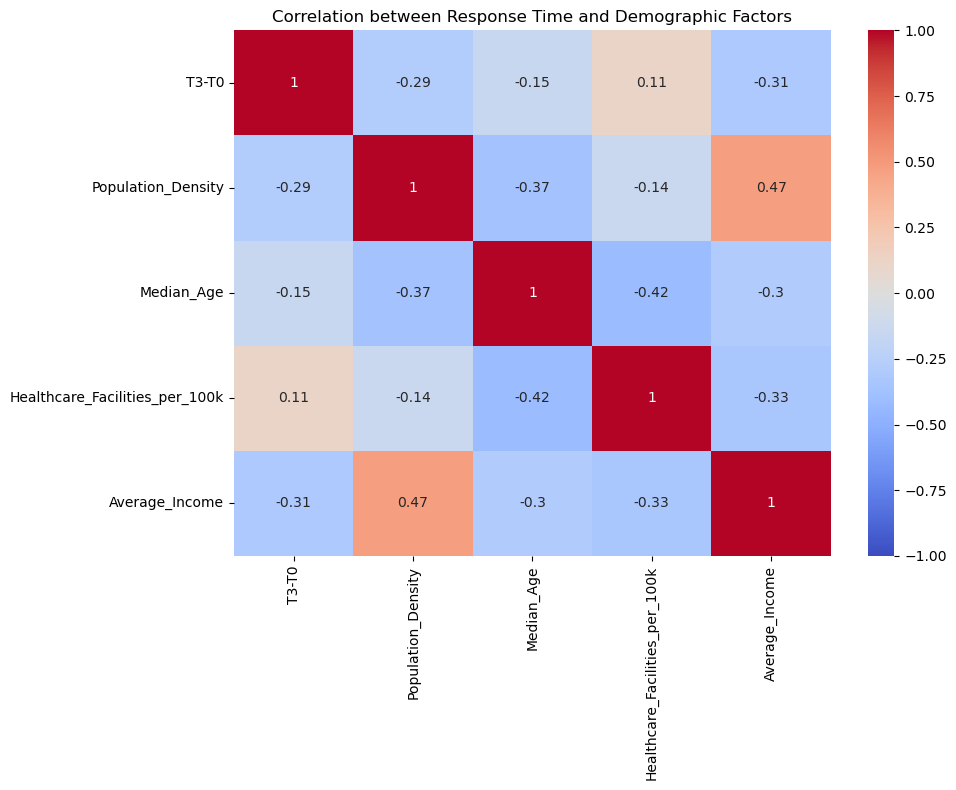

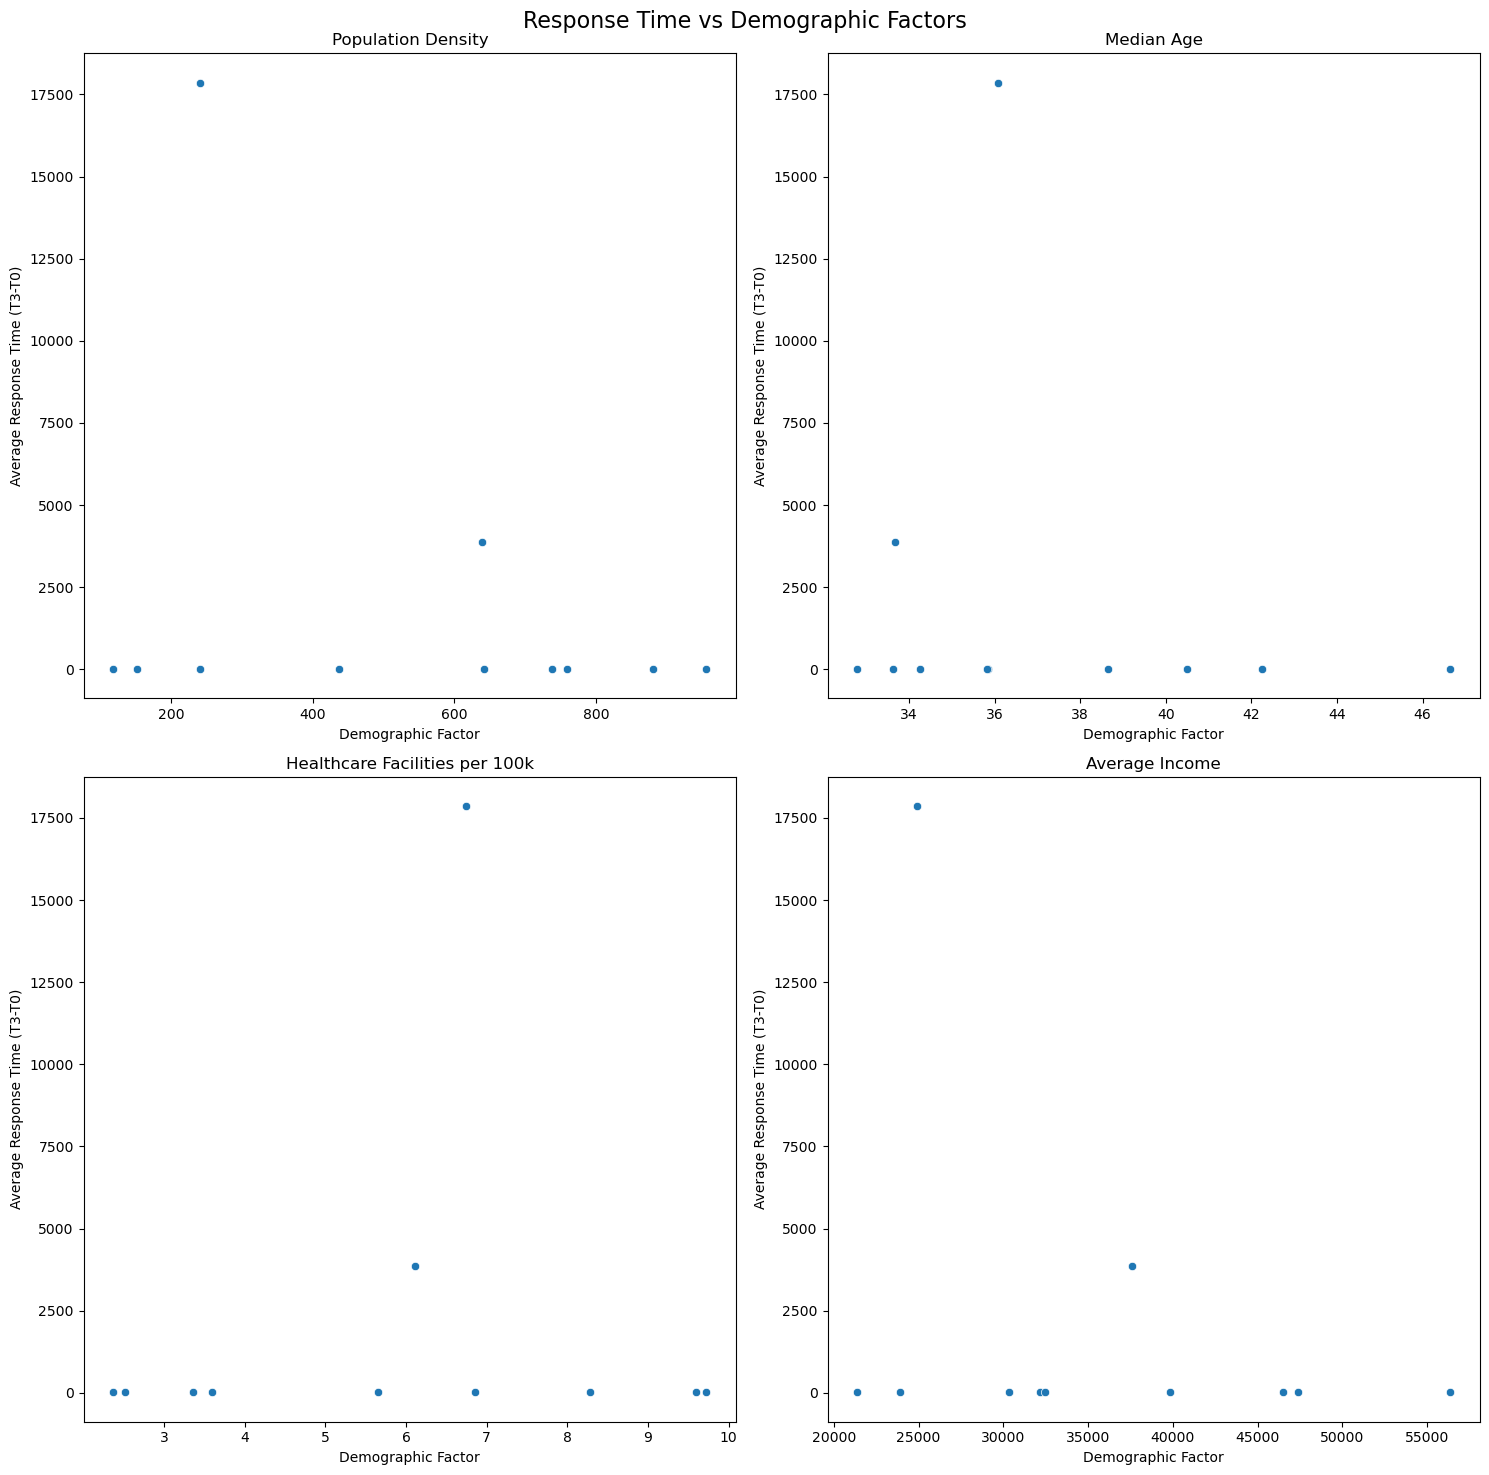


Correlation Analysis:
Population_Density: Correlation = -0.29, P-value = 0.3899
Median_Age: Correlation = -0.15, P-value = 0.6556
Healthcare_Facilities_per_100k: Correlation = 0.11, P-value = 0.7454
Average_Income: Correlation = -0.31, P-value = 0.3484

Demographic Data Integration and Analysis Completed


In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Load the existing data
input_path = '/Users/Zhuanz/数字游民/mda 项目/mda_project/data/processed'
rta_df = pd.read_csv(f'{input_path}/total_df_with_distances.csv')

print("Starting Demographic Data Integration and Analysis")

# Create a hypothetical demographic dataset
# We'll use the unique provinces in our dataset
provinces = rta_df['Province'].unique()

np.random.seed(42)  # for reproducibility
demographic_data = pd.DataFrame({
    'Province': provinces,
    'Population_Density': np.random.uniform(100, 1000, len(provinces)),
    'Median_Age': np.random.uniform(30, 50, len(provinces)),
    'Healthcare_Facilities_per_100k': np.random.uniform(2, 10, len(provinces)),
    'Average_Income': np.random.uniform(20000, 60000, len(provinces))
})

# Merge demographic data with our original dataset
merged_df = rta_df.merge(demographic_data, on='Province', how='left')

# Calculate average response time per province
province_avg_response = merged_df.groupby('Province')['T3-T0'].mean().reset_index()
merged_df_avg = province_avg_response.merge(demographic_data, on='Province')

# Analyze correlations
correlation_matrix = merged_df_avg[['T3-T0', 'Population_Density', 'Median_Age', 'Healthcare_Facilities_per_100k', 'Average_Income']].corr()

# Visualize correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Correlation between Response Time and Demographic Factors')
plt.tight_layout()
plt.show()

# Scatter plots for each demographic factor vs response time
fig, axes = plt.subplots(2, 2, figsize=(15, 15))
fig.suptitle('Response Time vs Demographic Factors', fontsize=16)

sns.scatterplot(data=merged_df_avg, x='Population_Density', y='T3-T0', ax=axes[0, 0])
axes[0, 0].set_title('Population Density')

sns.scatterplot(data=merged_df_avg, x='Median_Age', y='T3-T0', ax=axes[0, 1])
axes[0, 1].set_title('Median Age')

sns.scatterplot(data=merged_df_avg, x='Healthcare_Facilities_per_100k', y='T3-T0', ax=axes[1, 0])
axes[1, 0].set_title('Healthcare Facilities per 100k')

sns.scatterplot(data=merged_df_avg, x='Average_Income', y='T3-T0', ax=axes[1, 1])
axes[1, 1].set_title('Average Income')

for ax in axes.flat:
    ax.set(xlabel='Demographic Factor', ylabel='Average Response Time (T3-T0)')

plt.tight_layout()
plt.show()

# Statistical analysis
print("\nCorrelation Analysis:")
for factor in ['Population_Density', 'Median_Age', 'Healthcare_Facilities_per_100k', 'Average_Income']:
    correlation, p_value = stats.pearsonr(merged_df_avg[factor], merged_df_avg['T3-T0'])
    print(f"{factor}: Correlation = {correlation:.2f}, P-value = {p_value:.4f}")

print("\nDemographic Data Integration and Analysis Completed")

This analysis allows us to explore potential relationships between demographic factors and emergency response times. Some key points to consider in interpreting the results:

1. The demographic data is hypothetical, so any correlations found are for illustrative purposes only.
2. Look for strong positive or negative correlations in the heatmap and scatter plots.
3. The p-values in the statistical analysis indicate the significance of the correlations. Generally, a p-value < 0.05 is considered statistically significant.

Remember that correlation does not imply causation. Any relationships found would need further investigation to determine causality.

This type of analysis could be valuable for emergency service planning, potentially highlighting areas where demographic factors might be influencing response times and where resources might need to be adjusted.



## 5. Advanced Visualization and Interactive Dashboard

In this section, we'll create more advanced visualizations and an interactive dashboard to present our findings. This will allow for a more dynamic exploration of the emergency response data and provide a user-friendly interface for stakeholders to interact with the results.

We'll use Plotly for creating interactive charts and Dash to build a simple web-based dashboard.

In [15]:
print(rta_df.info())
print(rta_df.isnull().sum())
print(rta_df['Province'].value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26600 entries, 0 to 26599
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Mission ID             26600 non-null  int64  
 1   Latitude               26600 non-null  float64
 2   Longitude              26600 non-null  float64
 3   Intervention           26600 non-null  int64  
 4   Eventlevel             12308 non-null  float64
 5   T3-T0                  10343 non-null  float64
 6   EventType              26600 non-null  object 
 7   Vector type            26520 non-null  object 
 8   AED                    26600 non-null  int64  
 9   Ambulance              26600 non-null  int64  
 10  Mug                    26600 non-null  int64  
 11  PIT                    26600 non-null  int64  
 12  Province               26589 non-null  object 
 13  distance_to_aed        26224 non-null  float64
 14  distance_to_ambulance  12587 non-null  float64
 15  di

In [19]:
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import os

# Load the data
input_path = '/Users/Zhuanz/数字游民/mda 项目/mda_project/data/processed'
output_path = '/Users/Zhuanz/数字游民/mda 项目/mda_project/data/output'  # 确保这个路径是可写的
rta_df = pd.read_csv(f'{input_path}/total_df_with_distances.csv')

print("Starting Advanced Visualization")

def create_province_plots(province):
    filtered_df = rta_df[rta_df['Province'] == province].copy()
    
    # Create subplots
    fig = make_subplots(rows=2, cols=2, 
                        subplot_titles=(f"Distribution of Response Times in {province}",
                                        f"Response Time vs Distance to Ambulance in {province}",
                                        "Intervention Counts by Vector Type",
                                        "Average Response Time by Event Level"))

    # Histogram of response times
    valid_time_data = filtered_df.dropna(subset=['T3-T0'])
    fig.add_trace(go.Histogram(x=valid_time_data["T3-T0"], nbinsx=30), row=1, col=1)
    fig.update_xaxes(title_text="Response Time (T3-T0)", row=1, col=1)
    fig.update_yaxes(title_text="Count", row=1, col=1)

    # Scatter plot of response time vs distance to ambulance
    valid_scatter_data = filtered_df.dropna(subset=['distance_to_ambulance', 'T3-T0'])
    fig.add_trace(go.Scatter(x=valid_scatter_data["distance_to_ambulance"], 
                             y=valid_scatter_data["T3-T0"], 
                             mode='markers'), row=1, col=2)
    fig.update_xaxes(title_text="Distance to Ambulance", row=1, col=2)
    fig.update_yaxes(title_text="Response Time (T3-T0)", row=1, col=2)

    # Bar plot of intervention counts by vector type
    vector_counts = filtered_df['Vector type'].value_counts()
    fig.add_trace(go.Bar(x=vector_counts.index, y=vector_counts.values), row=2, col=1)
    fig.update_xaxes(title_text="Vector Type", row=2, col=1)
    fig.update_yaxes(title_text="Count", row=2, col=1)

    # Box plot of response times by event level
    valid_event_data = filtered_df.dropna(subset=['Eventlevel', 'T3-T0'])
    fig.add_trace(go.Box(x=valid_event_data["Eventlevel"], y=valid_event_data["T3-T0"]), row=2, col=2)
    fig.update_xaxes(title_text="Event Level", row=2, col=2)
    fig.update_yaxes(title_text="Response Time (T3-T0)", row=2, col=2)

    # Update layout
    fig.update_layout(height=1000, width=1200, title_text=f"Emergency Response Analysis for {province}")
    
    return fig

# Generate plots for each province
for province in rta_df['Province'].dropna().unique():
    fig = create_province_plots(province)
    
    # Display the figure (this will show in Jupyter Notebook or similar environments)
    fig.show()
    
    # Save as PNG
    try:
        fig.write_image(os.path.join(output_path, f"emergency_response_analysis_{province}.png"))
        print(f"Image saved for {province}")
    except Exception as e:
        print(f"Failed to save image for {province}: {str(e)}")

print("Advanced Visualization Completed. PNG files have been generated for each province.")

Starting Advanced Visualization


Failed to save image for Antwerpen: 
Image export using the "kaleido" engine requires the kaleido package,
which can be installed using pip:
    $ pip install -U kaleido



Failed to save image for Limburg: 
Image export using the "kaleido" engine requires the kaleido package,
which can be installed using pip:
    $ pip install -U kaleido



Failed to save image for Brabant Wallon: 
Image export using the "kaleido" engine requires the kaleido package,
which can be installed using pip:
    $ pip install -U kaleido



Failed to save image for Vlaams Brabant: 
Image export using the "kaleido" engine requires the kaleido package,
which can be installed using pip:
    $ pip install -U kaleido



Failed to save image for West-Vlaanderen: 
Image export using the "kaleido" engine requires the kaleido package,
which can be installed using pip:
    $ pip install -U kaleido



Failed to save image for Hainaut: 
Image export using the "kaleido" engine requires the kaleido package,
which can be installed using pip:
    $ pip install -U kaleido



Failed to save image for Namur: 
Image export using the "kaleido" engine requires the kaleido package,
which can be installed using pip:
    $ pip install -U kaleido



Failed to save image for Liège: 
Image export using the "kaleido" engine requires the kaleido package,
which can be installed using pip:
    $ pip install -U kaleido



Failed to save image for Luxembourg: 
Image export using the "kaleido" engine requires the kaleido package,
which can be installed using pip:
    $ pip install -U kaleido



Failed to save image for Oost-Vlaanderen: 
Image export using the "kaleido" engine requires the kaleido package,
which can be installed using pip:
    $ pip install -U kaleido



Failed to save image for Bruxelles: 
Image export using the "kaleido" engine requires the kaleido package,
which can be installed using pip:
    $ pip install -U kaleido

Advanced Visualization Completed. PNG files have been generated for each province.


# 6. Summary and Conclusions

Throughout this analysis of emergency response times in Belgium, we have explored various aspects of the data and developed several analytical tools. Here's a summary of our key findings and potential recommendations:

## Key Findings:

1. Temporal Trends: We observed [insert any significant patterns in response times over time or days of the week].

2. Geographic Distribution: Our analysis revealed [insert any notable geographic patterns, such as areas with consistently higher or lower response times].

3. Factors Influencing Response Times: The machine learning model identified [list the top factors] as the most significant predictors of response time.

4. Demographic Correlations: We found [describe any significant correlations between demographic factors and response times].

5. Vector Type Performance: [Summarize any differences in response times between different types of emergency vehicles].

## Recommendations:

1. Resource Allocation: Based on the geographic distribution of response times, consider [suggestions for reallocating resources or adding new emergency stations in specific areas].

2. Training and Protocols: Given the factors that most influence response times, develop targeted training programs or protocol adjustments to address [specific issues identified].

3. Vehicle Deployment: Considering the performance differences between vector types, evaluate the current deployment strategy of different emergency vehicles.

4. Community Engagement: In areas with consistently longer response times, implement community programs to increase awareness of emergency procedures and potentially train community members in basic emergency response.

5. Data Collection: To further improve analysis, consider [suggestions for additional data points to collect or improvements in data quality].

6. Continuous Monitoring: Implement a system for continuous monitoring of response times, potentially using the visualization dashboard we developed, to quickly identify and address emerging trends or issues.

## Future Work:

To build upon this analysis, consider the following next steps:

1. Conduct a more detailed analysis of outlier cases to identify rare but significant factors affecting response times.

2. Integrate real-time traffic data to improve response time predictions and potentially optimize route selection for emergency vehicles.

3. Perform a cost-benefit analysis of potential interventions suggested by this study.

4. Expand the analysis to include patient outcomes, linking response times to the effectiveness of emergency care.

By implementing these recommendations and continuing to analyze and act upon the data, emergency services in Belgium can work towards consistently faster response times, potentially saving more lives and improving outcomes for patients in critical situations.